In [1]:
#pip install xgboost

In [ ]:
#source: https://www.kaggle.com/code/ysthehurricane/bitcoin-dogecoin-etc-price-prediction-xgboost/comments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import plotly.express as px
import ta

import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from xgboost import XGBRegressor
from functools import reduce

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
close=pd.read_csv('data_updated/close.csv')
adj_close=pd.read_csv('data_updated/adj_close.csv')
open=pd.read_csv('data_updated/open.csv')
high=pd.read_csv('data_updated/open.csv')
low=pd.read_csv('data_updated/low.csv')
volume=pd.read_csv('data_updated/volume.csv')

In [4]:
dataframes = [close, adj_close, open, high, low, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)

In [5]:
def currency(curr): 
    df=df_merged[['Date',curr+'_x', curr+'_y']]
    df.columns = ['Date','Close', 'Adj_Close','Open','High', 'Low', 'Volume']
    df = ta.utils.dropna(df)
    return df

In [6]:
ada=currency('ADA-USD')
atom=currency('ATOM-USD')
avax=currency('AVAX-USD')
axs=currency('AXS-USD')
btc=currency('BTC-USD')
eth=currency('ETH-USD')
link=currency('LINK-USD')
luna1=currency('LUNA1-USD')
matic=currency('MATIC-USD')
sol=currency('SOL-USD')

#Dictionary with crypto names and datasets
crypto_names = {'ADA-USD':ada, 
               'ATOM-USD':atom,
               'AVAX-USD':avax,
               'AXS-USD':axs,
               'BTC-USD':btc,
               'ETH-USD':eth,
               'LINK-USD':link,
               'LUNA1-USD':luna1,
               'MATIC-USD':matic,
               'SOL-USD':sol}

In [7]:
#baseline for a currency
curr = btc[btc['Date'] > '2021-01-01']
curr = curr['Close']
curr_scale = pd.DataFrame(MinMaxScaler().fit_transform(np.array(curr).reshape(-1,1)))

#scaled data
baseline_ytest_scale = curr_scale[1:]
baseline_predictions_scale = curr_scale[:-1]
print("Scaled Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest_scale, baseline_predictions_scale))))

#unscaled data
baseline_ytest = curr[1:]
baseline_predictions = curr[:-1]

print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(baseline_ytest, baseline_predictions))))

Scaled Root Mean squared Error - RMSE : 0.04704749026586088
Root Mean squared Error - RMSE : 1776.4887897974795


#  Bitcoin Close Price Prediction using XGBoost

In [47]:
def predict_coin(curr,df, date, time_step=5):
    df = df.copy()
    df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
    df['date'] = pd.to_datetime(df.date)
    
    #create dataframe with needed features
    closedf = df[['date','close',"trend_macd"]]
    
    closedf = closedf[closedf['date'] > date]
    close_stock = closedf.copy()

    #set training size
    training_size=int(len(closedf)*0.80)
    test_size=len(closedf)-training_size
    train_data,test_data=closedf.iloc[0:training_size,:],closedf.iloc[training_size:len(closedf),:]
    
    #normalize price
    del train_data['date']
    del test_data['date']
    scaler = MinMaxScaler()
    scaler_y = MinMaxScaler().fit(np.array(train_data['close']).reshape(-1,1)) 
    scaler.fit(train_data)
    X_train_scaled = pd.DataFrame(scaler.transform(train_data)) 
    X_test_scaled = pd.DataFrame(scaler.transform(test_data))
    
    #create the looped datasets for "close"
    X_train, y_train = create_dataset(X_train_scaled, time_step)
    X_test, y_test = create_dataset(X_test_scaled, time_step)
    
    #convert to dataframes
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    #append variables
    X_train = pd.concat([X_train, X_train_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)
    X_test = pd.concat([X_test, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True)

    #convert back to array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    #build model
    my_model2 = XGBRegressor(n_estimators=1000)
    my_model2.fit(X_train, y_train, verbose=True)
    
    #get predictions
    predictions = my_model2.predict(X_test)
    scaled_rmse = math.sqrt(mean_squared_error(y_test, predictions))
    
    train_predict=my_model2.predict(X_train)
    test_predict=my_model2.predict(X_test)

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)

    # Transform back to original form
    train_predict = scaler_y.inverse_transform(train_predict)
    test_predict = scaler_y.inverse_transform(test_predict)
    original_ytrain = scaler_y.inverse_transform(y_train.reshape(-1,1)) 
    original_ytest = scaler_y.inverse_transform(y_test.reshape(-1,1)) 
    
    #get unscaled rmse 
    RMSE = math.sqrt(mean_squared_error(original_ytest, test_predict))
    trainRMSE = math.sqrt(mean_squared_error(original_ytrain, train_predict))
    
    #Predicting tomorrow
    tomorrow_scaled = my_model2.predict(X_test)[-1]
    tomorrow = scaler_y.inverse_transform(tomorrow_scaled.reshape(-1,1)) 
    
    #Predicting day after tomorrow
    appended_X_test_scaled = X_test_scaled.append([float(tomorrow_scaled)], ignore_index = True)
    X_test_append, y_test_append = create_dataset(appended_X_test_scaled, time_step)
    
    #adding tomorrows variables to dataframe 
    X_test_append = pd.DataFrame(X_test_append)
    X_test_append = pd.concat([X_test_append, X_test_scaled.iloc[time_step + 1:,1:].reset_index(drop=True)], axis = 1, ignore_index = True).fillna(method="ffill")
    
    #predicting day after tomorrow 
    tomorrow_tomorrow_scaled = my_model2.predict(X_test_append)[-1]
    tomorrow_tomorrow = scaler_y.inverse_transform(tomorrow_tomorrow_scaled.reshape(-1,1)) 
    
    #create output
    output = [curr,round(RMSE,4),round(trainRMSE,4), round(float(tomorrow),4), round(float(tomorrow_tomorrow),4) ]
    return pd.DataFrame(output).T

In [48]:
ada_output = predict_coin("ada",ada,date='2021-08-01', time_step=15)
atom_output = predict_coin("atom",atom,date='2021-01-01')
avax_output = predict_coin("avax",avax,date='2021-07-01')
axs_output = predict_coin("axs",axs,date='2021-07-01')
btc_output = predict_coin("btc",btc,date='2021-05-01', time_step=17)
eth_output = predict_coin("eth",eth,date='2021-02-01', time_step=17)
link_output = predict_coin("link",link,date='2021-07-01', time_step=17)
luna1_output = predict_coin("luna1",luna1,date='2021-05-01')
matic_output = predict_coin("matic",matic,date='2021-07-01')
sol_output = predict_coin("sol",sol,date='2021-07-01')

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\mdurh\a

In [33]:
predict_coin("atom",atom,date='2021-01-01', time_step=5)

C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\mdurh\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,0,1,2,3,4
0,atom,2.0443,0.053,20.288,17.201


In [49]:
#5 day default
final = pd.concat([ada_output, atom_output, avax_output, axs_output, btc_output, eth_output, link_output,
        luna1_output, matic_output, sol_output], axis=0)
final.columns = ["Currency", "RMSE Test","RMSE Train","2022-05-09","2022-05-10"]
final

,Currency,RMSE Test,RMSE Train,2022-05-09,2022-05-10
0,ada,0.0751,0.0017,0.8413,0.8344
0,atom,2.0443,0.053,20.288,17.201
0,avax,5.1595,0.1644,57.2125,55.3123
0,axs,4.4735,0.2019,34.3992,34.3992
0,btc,1198.0037,32.7668,36127.7891,36167.7852
0,eth,138.4708,2.8658,2690.8298,2690.8298
0,link,1.9237,0.0161,14.5628,14.5628
0,luna1,13.2402,0.111,73.389,62.9518
0,matic,0.0658,0.0026,1.0079,0.9689
0,sol,6.0528,0.3343,92.6217,72.2061


In [31]:
#17day default
final = pd.concat([ada_output, atom_output, avax_output, axs_output, btc_output, eth_output, link_output,
        luna1_output, matic_output, sol_output], axis=0)
final.columns = ["Currency", "RMSE Test","RMSE Train","2022-05-09","2022-05-10"]
final

,Currency,RMSE Test,RMSE Train,2022-05-09,2022-05-10
0,ada,0.0751,0.0017,0.8413,0.8344
0,atom,2.5746,0.028,22.1718,22.3061
0,avax,5.4368,0.097,56.9615,56.0501
0,axs,14.6442,0.1187,58.5219,58.1772
0,btc,1198.0037,32.7668,36127.7891,36167.7852
0,eth,138.4708,2.8658,2690.8298,2690.8298
0,link,1.9237,0.0161,14.5628,14.5628
0,luna1,20.4496,0.0761,66.9594,61.4451
0,matic,0.0745,0.0017,1.096,1.102
0,sol,7.7828,0.176,91.6957,88.9937


In [50]:
final.to_csv('XGB_updated.csv')

Text(0.5, 1.0, 'Bitcoin Close Price')

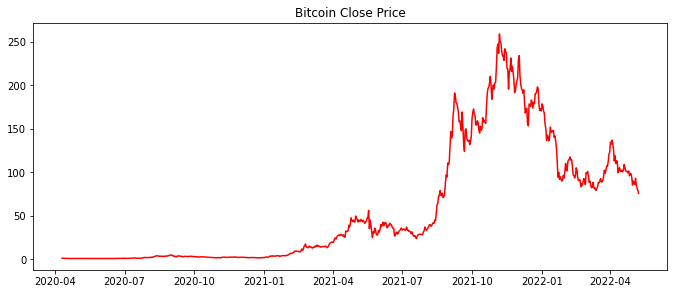

In [11]:
sol['Date'] = pd.to_datetime(sol.Date)
fig = plt.figure(figsize = (25,10))

plt.subplot(2, 2, 1)
plt.plot(sol['Date'], sol['Close'], color="red")
plt.title('Bitcoin Close Price')

In [33]:
final = pd.concat([ada_output, atom_output, avax_output, axs_output, btc_output, eth_output, link_output,
        luna1_output, matic_output, sol_output], axis=0)
final.columns = ["Currency", "RMSE","2022-05-09","2022-05-10"]
final

,Currency,RMSE,Tomorrow,Tomorrow+1
0,ada,0.06938530571025403,0.910327,0.910327
0,atom,2.1713252908137455,21.980719,21.551289
0,avax,5.2213154842955625,71.17643,71.17643
0,axs,5.776248206855418,56.342484,55.716213
0,btc,1048.1548257124612,39026.050781,39959.550781
0,eth,130.52684366653097,2870.135254,2865.402344
0,link,0.8681123785785104,14.506732,14.440706
0,luna1,20.364699475131307,72.640503,75.514297
0,matic,0.07870155168865467,1.259168,1.276718
0,sol,6.856162867759423,109.433052,103.558243
